In [1]:
import os
import pickle
from ase.db import connect
from ase.visualize import view

from GAMERNet.rnet.networks.reaction_network import ReactionNetwork
from GAMERNet.rnet.networks.surface import Surface

with open('../scripts/c1au111/rxn_net.pkl', 'rb') as pickle_file:
    content = pickle.load(pickle_file)  # dict of elementary reactions

rxn_net = ReactionNetwork().from_dict(content)
print(rxn_net)
graph = rxn_net.graph

ReactionNetwork(43 intermediates, 14 closed-shell molecules, 103 reactions)
Surface: Au48(111)
Network Carbon cutoff: C1



In [6]:
# steps from CO2(g) to MeOH(g)
rxn_net.get_shortest_path('102101g', '144101g')

(6,
 ['102101*(CO2*)<->000000*(Au48*)+102101g(CO2(g))',
  '113101*(CHO3*)+000000*(Au48*)<->011101*(HO*)+102101*(CO2*)',
  '124101*(CH2O4*)+000000*(Au48*)<->113101*(CHO3*)+011101*(HO*)',
  '134101*(CH3O4*)+000000*(Au48*)<->010101*(H*)+124101*(CH2O4*)',
  '144101*(CH4O4*)+000000*(Au48*)<->134101*(CH3O4*)+010101*(H*)',
  '144101*(CH4O4*)<->144101g(CH4O4(g))+000000*(Au48*)'])

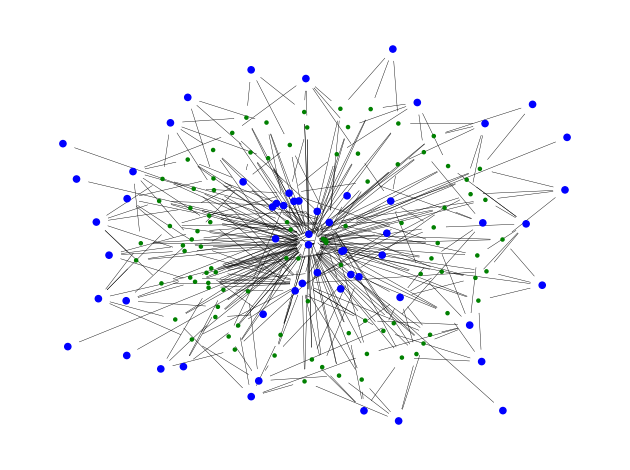

In [2]:
rxn_net.draw_graph()

In [2]:
rxn_net.add_eley_rideal('101101g', '001101*', '102101*')
print(rxn_net)

ReactionNetwork(43 intermediates, 14 closed-shell molecules, 104 reactions)
Surface: Au48(111)
Network Carbon cutoff: C1



In [3]:
print(len(rxn_net.reactions))

1136


In [2]:
print(len(rxn_net.reactions))

103


In [3]:
counter  =0 
for reaction in rxn_net.reactions:
    counter += 1
    print(counter, reaction.code, reaction.components, reaction.r_type)

1 000000*(Au48*)+140101*(CH4*)<->130101*(CH3*)+010101*(H*) (frozenset({140101*(CH4*), 000000*(Au48*)}), frozenset({010101*(H*), 130101*(CH3*)})) C-H
2 130101*(CH3*)+000000*(Au48*)<->010101*(H*)+120101*(CH2*) (frozenset({000000*(Au48*), 130101*(CH3*)}), frozenset({010101*(H*), 120101*(CH2*)})) C-H
3 000000*(Au48*)+120101*(CH2*)<->010101*(H*)+110101*(CH*) (frozenset({000000*(Au48*), 120101*(CH2*)}), frozenset({010101*(H*), 110101*(CH*)})) C-H
4 000000*(Au48*)+110101*(CH*)<->010101*(H*)+100101*(C*) (frozenset({000000*(Au48*), 110101*(CH*)}), frozenset({010101*(H*), 100101*(C*)})) C-H
5 000000*(Au48*)+142101*(CH4O2*)<->010101*(H*)+132101*(CH3O2*) (frozenset({000000*(Au48*), 142101*(CH4O2*)}), frozenset({010101*(H*), 132101*(CH3O2*)})) O-H
6 000000*(Au48*)+142101*(CH4O2*)<->010101*(H*)+132102*(CH3O2*) (frozenset({000000*(Au48*), 142101*(CH4O2*)}), frozenset({132102*(CH3O2*), 010101*(H*)})) C-H
7 132101*(CH3O2*)+000000*(Au48*)<->010101*(H*)+122101*(CH2O2*) (frozenset({132101*(CH3O2*), 000000

In [4]:
for reaction in rxn_net.reactions:
    print(reaction.components)
    for component in reaction.components:
        for inter in component:
            print(inter.code)

(frozenset({140101*(CH4*), 000000*(Au48*)}), frozenset({010101*(H*), 130101*(CH3*)}))
140101*
000000*
010101*
130101*
(frozenset({000000*(Au48*), 130101*(CH3*)}), frozenset({010101*(H*), 120101*(CH2*)}))
000000*
130101*
010101*
120101*
(frozenset({000000*(Au48*), 120101*(CH2*)}), frozenset({010101*(H*), 110101*(CH*)}))
000000*
120101*
010101*
110101*
(frozenset({000000*(Au48*), 110101*(CH*)}), frozenset({010101*(H*), 100101*(C*)}))
000000*
110101*
010101*
100101*
(frozenset({000000*(Au48*), 142101*(CH4O2*)}), frozenset({010101*(H*), 132101*(CH3O2*)}))
000000*
142101*
010101*
132101*
(frozenset({000000*(Au48*), 142101*(CH4O2*)}), frozenset({132102*(CH3O2*), 010101*(H*)}))
000000*
142101*
132102*
010101*
(frozenset({132101*(CH3O2*), 000000*(Au48*)}), frozenset({010101*(H*), 122101*(CH2O2*)}))
132101*
000000*
010101*
122101*
(frozenset({132101*(CH3O2*), 000000*(Au48*)}), frozenset({122102*(CH2O2*), 010101*(H*)}))
132101*
000000*
122102*
010101*
(frozenset({132102*(CH3O2*), 000000*(Au48*)}

In [ ]:
print(len(rxn_net.intermediates))

In [ ]:
closed_shell_atoms = []
for inter in rxn_net.intermediates.values():
    if inter.closed_shell == True:
        closed_shell_atoms.append(inter.molecule)
print(len(closed_shell_atoms))

In [ ]:
closed_shell_atoms = []
for inter in rxn_net.intermediates.values():
    if inter.closed_shell == True:
        closed_shell_atoms.append(inter.molecule)
print(len(closed_shell_atoms))

In [ ]:
closed_shell_atoms[0].get_chemical_symbols().count("H")

In [ ]:
view(closed_shell_atoms)

In [5]:
y = rxn_net.gen_graph()
# y.remove_node("")
for node in y.nodes(data=True):
    print(node)
print(y)

('140101*', {'category': 'intermediate', 'gas_atoms': Atoms(symbols='CH4', pbc=False, conn_pairs=...), 'code': '140101*', 'formula': 'CH4*', 'fig_path': '/home/smorandi/care/notebooks/140101*.png'})
('130101*', {'category': 'intermediate', 'gas_atoms': Atoms(symbols='CH3', pbc=False, conn_pairs=...), 'code': '130101*', 'formula': 'CH3*', 'fig_path': '/home/smorandi/care/notebooks/130101*.png'})
('120101*', {'category': 'intermediate', 'gas_atoms': Atoms(symbols='CH2', pbc=False, conn_pairs=...), 'code': '120101*', 'formula': 'CH2*', 'fig_path': '/home/smorandi/care/notebooks/120101*.png'})
('110101*', {'category': 'intermediate', 'gas_atoms': Atoms(symbols='CH', pbc=False, conn_pairs=...), 'code': '110101*', 'formula': 'CH*', 'fig_path': '/home/smorandi/care/notebooks/110101*.png'})
('100101*', {'category': 'intermediate', 'gas_atoms': Atoms(symbols='C', pbc=False, conn_pairs=...), 'code': '100101*', 'formula': 'C*', 'fig_path': '/home/smorandi/care/notebooks/100101*.png'})
('000000*',

In [ ]:
rxn_net.surface.facet

In [3]:
rxn_net.write_dotgraph(".", 'testCOLI2_ER.png')

ads
ads
ads
ads
ads
surf
ads
ads
ads
ads
ads
ads
ads
ads
ads
ads
ads
ads
ads
ads
ads
ads
ads
ads
ads
ads
ads
ads
ads
ads
ads
ads
ads
ads
ads
ads
ads
ads
ads
ads
ads
ads
ads
ads
gas
gas
gas
gas
gas
gas
gas
gas
gas
gas
gas
gas
gas
gas
surface_reaction
surface_reaction
surface_reaction
surface_reaction
surface_reaction
surface_reaction
surface_reaction
surface_reaction
surface_reaction
surface_reaction
surface_reaction
surface_reaction
surface_reaction
surface_reaction
surface_reaction
surface_reaction
surface_reaction
surface_reaction
surface_reaction
surface_reaction
surface_reaction
surface_reaction
surface_reaction
surface_reaction
surface_reaction
surface_reaction
surface_reaction
surface_reaction
surface_reaction
surface_reaction
surface_reaction
surface_reaction
surface_reaction
surface_reaction
surface_reaction
surface_reaction
surface_reaction
surface_reaction
surface_reaction
surface_reaction
surface_reaction
surface_reaction
surface_reaction
surface_reaction
surface_reaction
su

Look for intermediates with specified composition

In [ ]:
rxn_net.search_inter_by_elements({'C':1, 'H':2, 'O':2})

Look for all elementary steps involving a specific intermediate

In [ ]:
rxn_net.search_ts(["222101"])

In [ ]:
types = []
for reaction in rxn_net.reactions:
    types.append(reaction.r_type)
print(set(types))

In [ ]:
types = []
for inter in rxn_net.intermediates.values():
    types.append(inter.phase)
print(set(types))

# closed shell

In [ ]:
def is_closed_shell_santi(self):
        """
        Check if a molecule CxHyOz is closed-shell or not.
        """
        graph = self.graph
        # print(graph.nodes()) list of node indexes, element symbol stored as "elem"
        molecule = self.molecule
        valence_electrons = {'C': 4, 'H': 1, 'O': 2}
        graph = graph.to_undirected()
        mol_composition = molecule.get_chemical_symbols()
        mol = {'C': mol_composition.count('C'), 'H': mol_composition.count('H'), 'O': mol_composition.count('O')} # CxHyOz

        if mol['C'] != 0 and mol['H'] == 0 and mol['O'] == 0: # Cx
                return False
        elif mol['C'] == 0 and mol['H'] != 0 and mol['O'] == 0: # Hy
                return True if mol['H'] == 2 else False
        elif mol['C'] == 0 and mol['H'] == 0 and mol['O'] != 0: # Oz
                return True if mol['O'] == 2 else False
        elif mol['C'] != 0 and mol['H'] == 0 and mol['O'] != 0: # CxOz
                return True if mol['C'] == 1 and mol['O'] in (1,2) else False
        elif mol['C'] != 0 and mol['H'] != 0: # CxHyOz (z can be zero)
            node_val = lambda graph: {node: (graph.degree(node), 
                                        valence_electrons.get(graph.nodes[node]["elem"], 0)) for node in graph.nodes()}
            num_unsaturated_nodes = lambda dict: len([node for node in dict.keys() if dict[node][0] < dict[node][1]])
            node_valence_dict = node_val(graph)
            if num_unsaturated_nodes(node_valence_dict): # all atoms are saturated
                return True
            elif num_unsaturated_nodes(node_valence_dict) == 1: # only one unsaturated atom
                return False
            else:
                saturation_condition = lambda dict: all(dict[node][0] == dict[node][1] for node in dict.keys())
                while saturation_condition(node_valence_dict) == False:
                    unsat_nodes = [node for node in node_valence_dict.keys() if node_valence_dict[node][0] < node_valence_dict[node][1]]
                    O_unsat_nodes = [node for node in unsat_nodes if graph.nodes[node]["elem"] == 'O']  # all oxygens unsaturated
                    if len(O_unsat_nodes) != 0: # only one unsaturated oxygen
                        for oxygen in O_unsat_nodes:
                            node_valence_dict[oxygen][0] += 1
                            # increase the valence of the oxygen neighbour by 1
                            for neighbour in graph.neighbors(oxygen): # only one neighbour
                                if node_valence_dict[neighbour][0] < node_valence_dict[neighbour][1]:
                                    node_valence_dict[neighbour][1] += 1
                                else:
                                    return False # O neighbour is saturated already
                    else: # CxHy
                         # select node with the highest degree
                        max_degree = max([node_valence_dict[node][0] for node in unsat_nodes])
                        max_degree_node = [node for node in unsat_nodes if node_valence_dict[node][0] == max_degree][0]
                        max_degree_node_unsat_neighbours = [neighbour for neighbour in graph.neighbors(max_degree_node) if neighbour in unsat_nodes]
                        if len(max_degree_node_unsat_neighbours) == 0: # all neighbours are saturated
                            return False
                        node_valence_dict[max_degree_node][0] += 1
                        node_valence_dict[max_degree_node_unsat_neighbours][0] += 1
                         
                            

                
        
        # # Getting the unsaturated nodes (if there are not unsaturated nodes, the molecule is closed-shell)
        # unsat_nodes = [node for node in graph.nodes() if graph.degree(node) < valence_electrons.get(graph.nodes[node]["elem"], 0)]

        # # If the graph only has Carbon as an element and not H or O, then it is open-shell
        # if not 'H' and 'O' in molecule.get_chemical_formula():
        #     print(f'System {molecule.get_chemical_formula()} is open-shell: only C atoms')
        #     return False 
        
        # # Specific case for O2
        # if not 'C' and 'H' in molecule.get_chemical_formula() and len(unsat_nodes) == 2:
        #     print(f'System {molecule.get_chemical_formula()} is closed-shell: Oxygen')
        #     return True 
        
        # # CO and CO2
        # if not 'H' in molecule.get_chemical_formula() and len(molecule.get_chemical_symbols()['C']) == 1 and len(molecule.get_chemical_symbols()['O']) in (1,2):
        #     print(f'System {molecule.get_chemical_formula()} is closed-shell: CO or CO2')
        #     return True
        
        # if unsat_nodes:
        #     # If the molecule has only one unsaturated node, then it is open-shell
        #     if len(unsat_nodes) == 1:
        #         print(f'System {molecule.get_chemical_formula()} is open-shell')
        #         return False 
        #     else:
        #         # Checking if there is one unsaturated node that does not have as neighbour another unsaturated node
        #         for node in unsat_nodes:
        #             # If the molecule has only one unsaturated node, then it is open-shell
        #             if not [n for n in graph.neighbors(node) if n in unsat_nodes]:
        #                 print(f'System {molecule.get_chemical_formula()} is open-shell: one node is unsaturated but does not have as neighbour another unsaturated node')
        #                 return False 
        #             else:
        #                 # Case for molecules where an unsaturated node is oxygen
        #                 if graph.nodes[node]["elem"] == 'O':
        #                     # Adding one bond order (valence electrons) to the oxygen node by adding it to the unsat_nodes list

In [ ]:
is_closed_shell_santi(rxn_net.intermediates['121101'])